In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random

In [2]:
# --- Paths ---
# Make sure these paths are correct for your system
train_dir = r"C:\Users\chris\Downloads\eclipse-megamovie (2)\eclipse-megamovie\train"
test_dir = r"C:\Users\chris\Downloads\eclipse-megamovie (2)\eclipse-megamovie\test"
train_csv = r"C:\Users\chris\Downloads\eclipse-megamovie (2)\eclipse-megamovie\train.csv"
test_csv = r"C:\Users\chris\Downloads\eclipse-megamovie (2)\eclipse-megamovie\test.csv"

In [3]:
# --- Load label files ---
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [4]:
# --- Add full paths ---
train_df['path'] = train_df['image_id'].apply(lambda x: os.path.join(train_dir, x))
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join(test_dir, x))

In [5]:
# --- Preprocessing ---
def preprocess_image(path, size=(256, 256)):
    img = cv2.imread(path)                                      # read image from file path
    img = cv2.resize(img, size)                                 # resize to 256x256
    img = cv2.GaussianBlur(img, (3, 3), 0)                      # apply gaussian blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                # convert image to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # create CLAHE
    return clahe.apply(gray)                                    # return preprocessed image, CLAHE applied

In [6]:
# --- Special Case Classification ---
def classify_flat_or_dark(img, flat_std_thresh=8, dark_mean_thresh=25, dark_std_thresh=6, path=""):
    """ Classify an image as Flat (6), Dark (4), or Unknown (None). """
    if img is None:
        return None                                             # return None if image is invalid

    mean_intensity = np.mean(img)                               # compute mean pixel intensity
    std_intensity = np.std(img)                                 # compute standard deviation of intensity
    median_intensity = np.median(img)                           # compute median pixel intensity
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()  # compute grayscale histogram
    dominant_pixel = np.argmax(hist)                            # find intensity value with highest frequency

    # classify as 'Dark' if very low brightness, low contrast, and mostly dark pixels
    if mean_intensity < dark_mean_thresh and std_intensity < dark_std_thresh and dominant_pixel < 20:
        return 4  # Dark

    # classify as 'Flat' if bright or mid-bright, but with low contrast and no strong dark peak
    elif mean_intensity > 80 and std_intensity < flat_std_thresh and dominant_pixel > 50:
        return 6  # Flat

    return None                                                 # otherwise, not classified as Flat or Dark

In [7]:
# --- SIFT - feature extract ---
def extract_sift_descriptors(df):
    sift = cv2.SIFT_create(contrastThreshold=0.075, edgeThreshold=12)  # create SIFT detector with custom thresholds
    descriptors_list = []                                              # store SIFT descriptors for each image
    special_classifications = []                                       # store special class (4=Dark, 6=Flat) or None

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting SIFT features"):  # loop through all images
        path = row['path']
        img_orig = cv2.imread(path)                                     # read original image for classification

        gray_processed = preprocess_image(path)                         # preprocess image for SIFT and classification

        # --- Early classify as Flat or Dark based on original grayscale image ---
        special_class = classify_flat_or_dark(gray_processed, path=path)  # classify as Flat/Dark if possible

        if special_class is not None:
            special_classifications.append(special_class)              # store special class (4 or 6)
            descriptors_list.append(None)                              # no need to extract descriptors
            continue                                                   # skip SIFT

        # --- If not Flat/Dark, proceed SIFT ---
        special_classifications.append(None)                           # mark as normal class

        if gray_processed is None:
            descriptors_list.append(None)                              # preprocessing failed, store None
            continue

        keypoints, descriptors = sift.detectAndCompute(gray_processed, None)  # extract SIFT features

        if descriptors is None or len(descriptors) == 0:
            descriptors_list.append(None)                              # no descriptors found, store None
        else:
            descriptors_list.append(descriptors)                       # store extracted descriptors

    return descriptors_list, special_classifications                   # return SIFT descriptors and special classes


In [8]:
# --- KMeans Vocabulary Building ---
def build_vocabulary(descriptors_list_normal, vocab_size):
    # Input should ONLY contain descriptors from non-Flat/Dark images
    descriptors = [desc for desc in descriptors_list_normal if desc is not None]   # filter out None entries
    if not descriptors:
        raise ValueError("No valid descriptors found to build vocabulary. Check SIFT extraction and filtering.")  # fail early if empty

    descriptors_stacked = np.vstack(descriptors)                                   # stack all descriptors into one array
    print(f"Building vocabulary from {len(descriptors)} images ({descriptors_stacked.shape[0]} total descriptors)...")

    kmeans = KMeans(n_clusters=vocab_size, random_state=42, n_init=10)             # create KMeans with defined vocab size
    kmeans.fit(descriptors_stacked)                                                # cluster descriptors to form visual words
    return kmeans                                                                  # return trained KMeans model

In [9]:
# --- Compute BoW Histograms (Slight adaptation for clarity/safety) ---
def compute_bow_histograms_normal(descriptors_list_normal, kmeans):
    vocab_size = kmeans.n_clusters                                          # number of visual words (clusters)
    histograms = []                                                         # list to store BoW histograms

    for descriptors in descriptors_list_normal:
        if descriptors is None or len(descriptors) == 0:
            hist = np.zeros(vocab_size)                                     # use zero histogram for missing descriptors
        else:
            words = kmeans.predict(descriptors)                             # assign descriptors to nearest visual words
            hist, _ = np.histogram(words, bins=np.arange(vocab_size + 1))   # compute histogram of visual word frequencies

        histograms.append(hist)                                             # store histogram

    return np.array(histograms)                                             # return all histograms as numpy array

In [10]:
# --- Execute Feature Extraction ---
print("Processing Training Data...")
train_descriptors_all, special_classifications_train = extract_sift_descriptors(train_df)  # extract SIFT descriptors and special classes for training set

print("Processing Test Data...")
test_descriptors_all, special_classifications_test = extract_sift_descriptors(test_df)     # extract SIFT descriptors and special classes for test set

Processing Training Data...


Extracting SIFT features: 100%|██████████████████████████████████████████████████████| 495/495 [01:14<00:00,  6.61it/s]


Processing Test Data...


Extracting SIFT features: 100%|██████████████████████████████████████████████████████| 140/140 [00:19<00:00,  7.02it/s]


In [11]:
# --- Filter Data: Separate Normal images from Flat/Dark ---

# 1. Get Indices
normal_train_indices = [i for i, sc in enumerate(special_classifications_train) if sc is None]      # indices of normal training images
special_train_indices = [i for i, sc in enumerate(special_classifications_train) if sc is not None] # indices of Flat/Dark training images
normal_test_indices = [i for i, sc in enumerate(special_classifications_test) if sc is None]        # indices of normal test images
special_test_indices = [i for i, sc in enumerate(special_classifications_test) if sc is not None]   # indices of Flat/Dark test images

# 2. Filter Descriptors and Labels for NORMAL images
train_descriptors_normal_valid = []                    # list to store valid SIFT descriptors for normal training images
y_train_normal_indices = []                            # track original indices for label alignment

for i in normal_train_indices:
    if train_descriptors_all[i] is not None and len(train_descriptors_all[i]) > 0:  # only keep non-empty descriptors
        train_descriptors_normal_valid.append(train_descriptors_all[i])             # store valid descriptors
        y_train_normal_indices.append(i)                                            # store corresponding index

test_descriptors_normal_valid = []                     # list to store valid SIFT descriptors for normal test images
y_test_normal_indices = []                             # track original indices for label alignment

for i in normal_test_indices:
    if test_descriptors_all[i] is not None and len(test_descriptors_all[i]) > 0:   # only keep non-empty descriptors
        test_descriptors_normal_valid.append(test_descriptors_all[i])              # store valid descriptors
        y_test_normal_indices.append(i)                                            # store corresponding index

# 3. Get Labels for NORMAL training images
y_train_normal = train_df['label'].values[y_train_normal_indices]  # fetch labels for valid normal training images

# Summary of filtering results
print(f"Training set: {len(train_df)} total, {len(special_train_indices)} special, {len(y_train_normal_indices)} normal with valid descriptors.")
print(f"Test set: {len(test_df)} total, {len(special_test_indices)} special, {len(y_test_normal_indices)} normal with valid descriptors.")

Training set: 495 total, 36 special, 429 normal with valid descriptors.
Test set: 140 total, 9 special, 122 normal with valid descriptors.


In [12]:
# --- Build Vocabulary (using ONLY normal training images) ---
vocab_size = 345                                                         # set the desired vocabulary size (number of clusters)
kmeans = build_vocabulary(train_descriptors_normal_valid, vocab_size)    # build vocabulary using KMeans on valid descriptors of normal images

Building vocabulary from 429 images (77128 total descriptors)...


In [13]:
# --- Compute BoW Histograms (using ONLY normal images) ---
print("Computing BoW histograms for Normal training images...")
X_train_normal = compute_bow_histograms_normal(train_descriptors_normal_valid, kmeans)  # compute BoW histograms for training set using normal images

print("Computing BoW histograms for Normal test images...")
X_test_normal = compute_bow_histograms_normal(test_descriptors_normal_valid, kmeans)    # compute BoW histograms for test set using normal images

Computing BoW histograms for Normal training images...
Computing BoW histograms for Normal test images...


In [14]:
# --- Normalize Features (using ONLY normal images) ---
scaler = StandardScaler()                                                     # initialize the StandardScaler for feature normalization

X_train_scaled_normal = scaler.fit_transform(X_train_normal)                   # fit scaler to training data and transform features

# Check if X_test_normal is empty before transforming
if X_test_normal.shape[0] > 0:                                                 # check if there are any normal test images with valid descriptors
    X_test_scaled_normal = scaler.transform(X_test_normal)                     # transform test data using the same scaler
else:
    # Handle case where there are no normal test images with descriptors
    X_test_scaled_normal = np.empty((0, vocab_size))                           # create an empty array for test data if no valid descriptors
    print("Warning: No 'normal' test images with valid descriptors found.")    # print a warning if no valid test descriptors

In [38]:
# --- Train Classifier (using ONLY normal images) ---
print("Training SVM on Normal images...")

# === GRID SEARCH CV FOR SVM ===
param_grid = {
    'C': [1, 10, 100],               # regularization parameter (C), reduced for faster run; adjust as needed
    'gamma': [0.001, 0.01, 0.1, 1],  # kernel coefficient (gamma), reduced for faster run; adjust as needed
    'kernel': ['rbf']                # radial basis function kernel
}

print("Running GridSearchCV for SVM...")
# Ensure there's data to train on
if X_train_scaled_normal.shape[0] > 0:                                       # check if there are valid training samples
    grid = GridSearchCV(SVC(), param_grid, cv=min(3, X_train_scaled_normal.shape[0]), verbose=2, n_jobs=-1)  # Grid search for optimal parameters
    grid.fit(X_train_scaled_normal, y_train_normal)                          # fit model with the training data
    print("Best SVM Parameters:", grid.best_params_)                         # print the best parameters found
    svm = grid.best_estimator_                                               # get the best model
else:
    raise SystemExit("Error: Cannot train SVM, no valid normal training samples.")  # exit if no valid training samples

Training SVM on Normal images...
Running GridSearchCV for SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\chris\miniconda3\envs\cs470--gpu\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best SVM Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [51]:
# --- Train Logistic Regression Classifier (using ONLY normal images) ---
print("Training Logistic Regression on Normal images...")

# === GRID SEARCH CV FOR LOGISTIC REGRESSION ===
param_grid_lr = {
    'C': [0.1, 1, 10],                # regularization parameter (C), adjust range as needed
    'solver': ['lbfgs', 'liblinear', 'saga'],  # solvers supported by logistic regression
    'max_iter': [100, 200],           # max iterations for convergence
}

print("Running GridSearchCV for Logistic Regression...")
# Ensure there's data to train on
if X_train_scaled_normal.shape[0] > 0:                                      # check if there are valid training samples
    grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=min(3, X_train_scaled_normal.shape[0]), verbose=2, n_jobs=-1)  # grid search for optimal parameters
    grid_lr.fit(X_train_scaled_normal, y_train_normal)                      # fit model with the training data
    print("Best Logistic Regression Parameters:", grid_lr.best_params_)     # print the best parameters found
    logreg = grid_lr.best_estimator_                                        # get the best model
else:
    raise SystemExit("Error: Cannot train Logistic Regression, no valid normal training samples.")  # exit if no valid training samples


Training Logistic Regression on Normal images...
Running GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\chris\miniconda3\envs\cs470--gpu\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Logistic Regression Parameters: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}


C:\Users\chris\miniconda3\envs\cs470--gpu\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
# --- Predict with SVM (on ONLY normal test images) ---
# Ensure there's data to predict on
if X_test_scaled_normal.shape[0] > 0:                                          # check if there are valid test samples
    y_pred_normal = svm.predict(X_test_scaled_normal)                          # make predictions using the trained SVM model
else:
    y_pred_normal = np.array([], dtype=int)                                    # no predictions if no normal test images

In [53]:
# --- Predict with Logistic Regression (on ONLY normal test images) ---
# Ensure there's data to predict on
if X_test_scaled_normal.shape[0] > 0:                                          # check if there are valid test samples
    y_pred_normal_lr = logreg.predict(X_test_scaled_normal)                    # make predictions using the trained Logistic Regression model
else:
    y_pred_normal_lr = np.array([], dtype=int)                                 # no predictions if no normal test images


In [54]:
# --- Combine Predictions and Ground Truth ---

# 1. Final Ground Truth (y_test_final)
y_test_final = test_df['label'].values.copy()                      # copy true labels from the test data to keep them intact

# 2. Final Predictions for SVM and LR (Separate arrays)
y_pred_final_svm = np.full(len(test_df), fill_value=4, dtype=int)  # initialize SVM predictions with a default value of 4 (Dark)
y_pred_final_lr = np.full(len(test_df), fill_value=4, dtype=int)   # initialize LR predictions with a default value of 4 (Dark)

# Fill in special classifications (Flat or Dark, based on the special classification list)
for i in special_test_indices:
    y_pred_final_svm[i] = special_classifications_test[i]          # use pre-classified values for special cases (4 or 6)
    y_pred_final_lr[i] = special_classifications_test[i]           # use pre-classified values for special cases (4 or 6)

# Fill in SVM predictions for normal images
# Ensure the lengths match before assigning predictions
if len(y_pred_normal) == len(y_test_normal_indices):
    for pred_idx, original_idx in enumerate(y_test_normal_indices):
        y_pred_final_svm[original_idx] = y_pred_normal[pred_idx]   # assign SVM predictions to the corresponding original indices
elif len(y_pred_normal) == 0 and len(y_test_normal_indices) == 0:
    print("No normal test images to predict with SVM.")            # handle case where no normal test images exist for SVM
else:
    print(f"Warning: Mismatch in length of SVM predictions ({len(y_pred_normal)}) and normal indices ({len(y_test_normal_indices)}). Predictions might be incomplete.") 

# Fill in Logistic Regression predictions for normal images
# Ensure the lengths match before assigning predictions
if len(y_pred_normal_lr) == len(y_test_normal_indices):
    for pred_idx, original_idx in enumerate(y_test_normal_indices):
        y_pred_final_lr[original_idx] = y_pred_normal_lr[pred_idx]  # assign LR predictions to the corresponding original indices
elif len(y_pred_normal_lr) == 0 and len(y_test_normal_indices) == 0:
    print("No normal test images to predict with LR.")              # handle case where no normal test images exist for LR
else:
    print(f"Warning: Mismatch in length of LR predictions ({len(y_pred_normal_lr)}) and normal indices ({len(y_test_normal_indices)}). Predictions might be incomplete.") 


--- Final Evaluation ---
SVM Test Accuracy: 0.7857


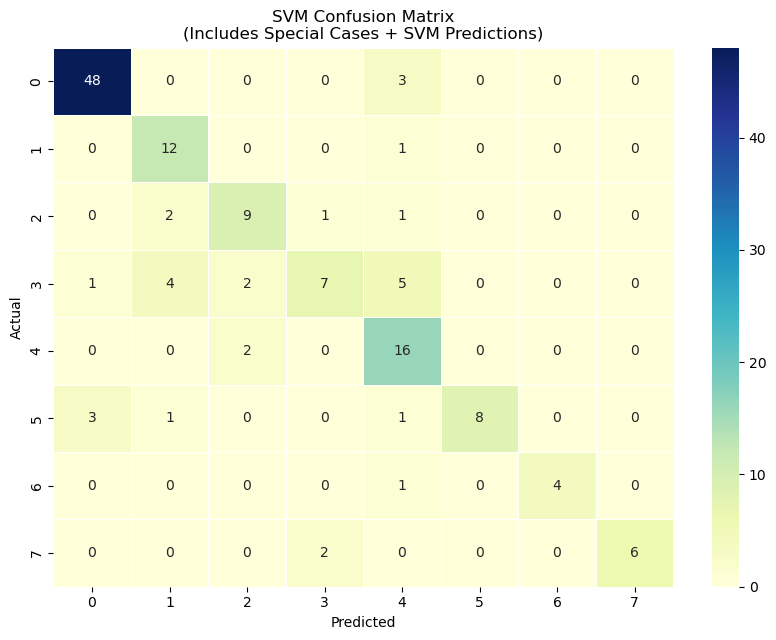


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        51
           1       0.63      0.92      0.75        13
           2       0.69      0.69      0.69        13
           3       0.70      0.37      0.48        19
           4       0.57      0.89      0.70        18
           5       1.00      0.62      0.76        13
           6       1.00      0.80      0.89         5
           7       1.00      0.75      0.86         8

    accuracy                           0.79       140
   macro avg       0.81      0.75      0.76       140
weighted avg       0.81      0.79      0.78       140

Logistic Regression Test Accuracy: 0.7643


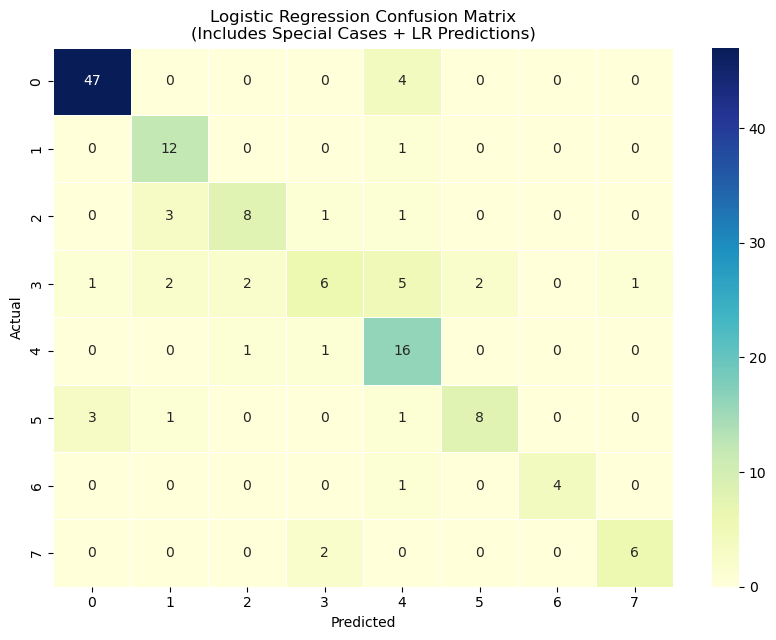


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        51
           1       0.67      0.92      0.77        13
           2       0.73      0.62      0.67        13
           3       0.60      0.32      0.41        19
           4       0.55      0.89      0.68        18
           5       0.80      0.62      0.70        13
           6       1.00      0.80      0.89         5
           7       0.86      0.75      0.80         8

    accuracy                           0.76       140
   macro avg       0.77      0.73      0.73       140
weighted avg       0.78      0.76      0.76       140



In [55]:
# --- Evaluate FINAL Results for SVM and Logistic Regression ---
print("\n--- Final Evaluation ---")

# Ensure there is test data to evaluate
if len(y_test_final) > 0:
    
    # SVM Evaluation
    acc_svm = accuracy_score(y_test_final, y_pred_final_svm)                      # svm accuracy score
    print(f"SVM Test Accuracy: {acc_svm:.4f}")                                    # svm accuracy

    # Confusion Matrix for SVM
    labels_svm = sorted(list(set(y_test_final) | set(y_pred_final_svm)))          # unique labels for SVM
    cm_svm = confusion_matrix(y_test_final, y_pred_final_svm, labels=labels_svm)  # confusion matrix for SVM
    df_cm_svm = pd.DataFrame(cm_svm, index=labels_svm, columns=labels_svm)

    # Plot Confusion Matrix for SVM
    plt.figure(figsize=(10, 7))
    plt.title("SVM Confusion Matrix\n(Includes Special Cases + SVM Predictions)")
    sns.heatmap(df_cm_svm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Print Classification Report for SVM
    print("\nSVM Classification Report:")
    print(classification_report(y_test_final, y_pred_final_svm, labels=labels_svm, zero_division=0))

    # Logistic Regression Evaluation
    acc_lr = accuracy_score(y_test_final, y_pred_final_lr)                         # logistic regression accuracy score
    print(f"Logistic Regression Test Accuracy: {acc_lr:.4f}")                      # logistic tegression accuracy

    # Confusion Matrix for Logistic Regression
    labels_lr = sorted(list(set(y_test_final) | set(y_pred_final_lr)))             # unique labels for Logistic Regression
    cm_lr = confusion_matrix(y_test_final, y_pred_final_lr, labels=labels_lr)      # confusion matrix for Logistic Regression
    df_cm_lr = pd.DataFrame(cm_lr, index=labels_lr, columns=labels_lr)

    # Plot Confusion Matrix for Logistic Regression
    plt.figure(figsize=(10, 7))
    plt.title("Logistic Regression Confusion Matrix\n(Includes Special Cases + LR Predictions)")
    sns.heatmap(df_cm_lr, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Print Classification Report for Logistic Regression
    print("\nLogistic Regression Classification Report:")
    print(classification_report(y_test_final, y_pred_final_lr, labels=labels_lr, zero_division=0))

else:
    print("No test data to evaluate.")                                             # handle case when there's no test data to evaluate



Found 30 misclassified images for SVM.
Found 33 misclassified images for LR.


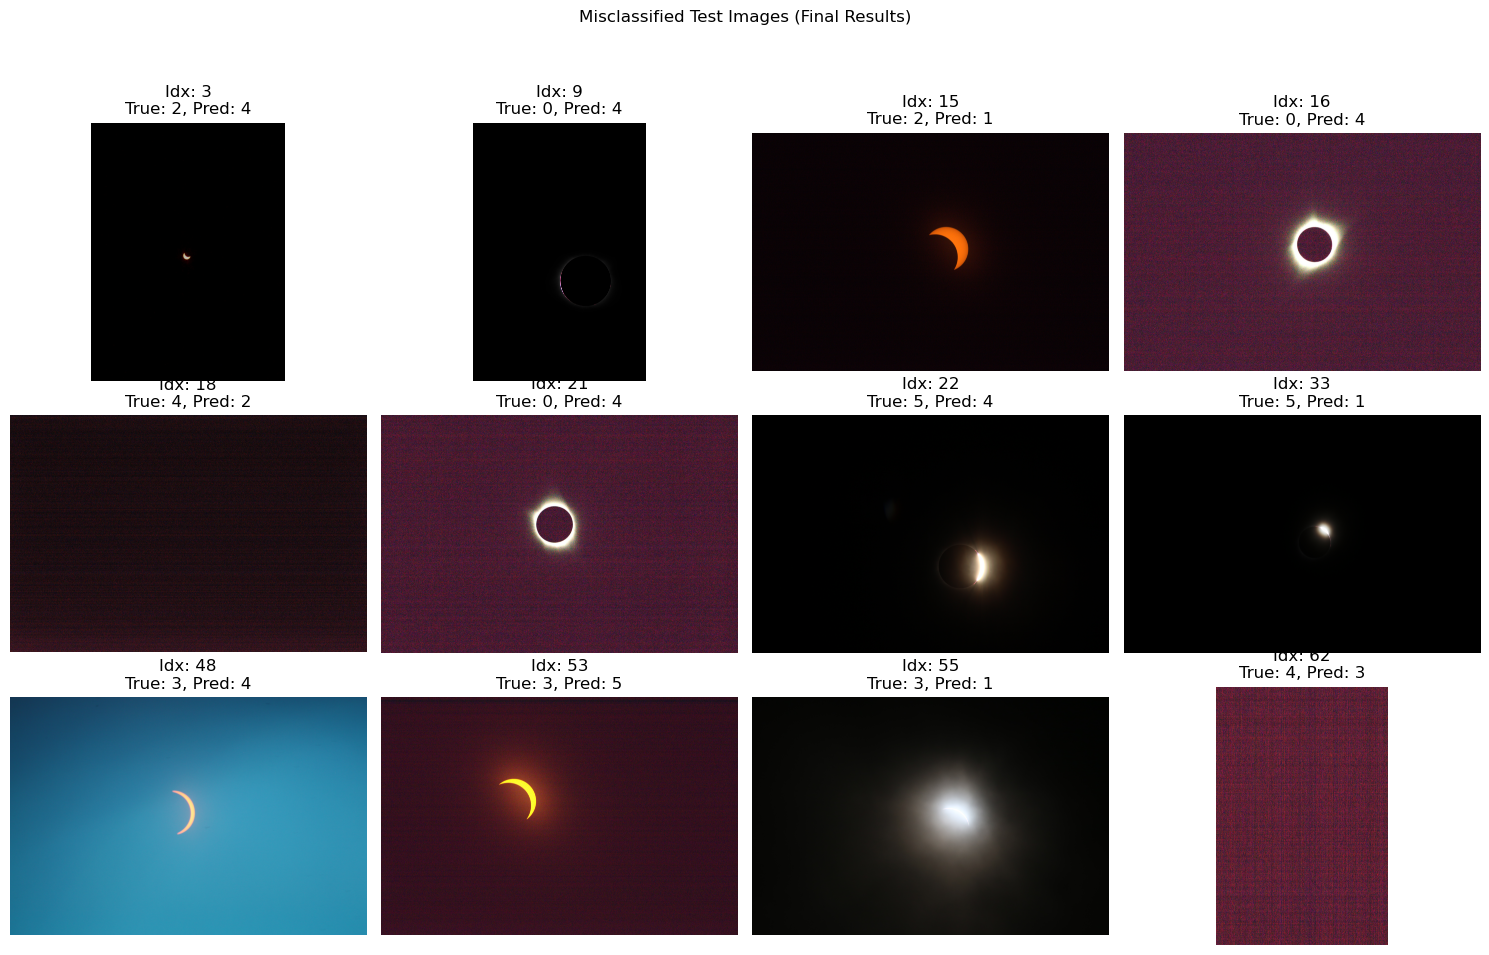

In [56]:
# --- Visualize Misclassified Images (Using SVM and LR Final Results) ---
if len(y_test_final) > 0:  # check if the test set has any samples
    # Identify misclassified indices for both SVM and Logistic Regression
    misclassified_indices_svm = np.where(y_pred_final_svm != y_test_final)[0]             # svm misclassified indices
    misclassified_indices_lr = np.where(y_pred_final_lr != y_test_final)[0]               # logistic regression misclassified indices
    
    print(f"\nFound {len(misclassified_indices_svm)} misclassified images for SVM.")
    print(f"Found {len(misclassified_indices_lr)} misclassified images for LR.")

    # Number of misclassified images to show
    num_to_show = min(12, len(misclassified_indices_svm), len(misclassified_indices_lr))  # limit to 12 or fewer misclassified images to display
    if num_to_show > 0:                                                                   # ensure there are misclassified images to show
        plt.figure(figsize=(15, 10))                                                      # set the figure size for the plot
        plot_rows = (num_to_show + 3) // 4                                                # calculate the number of rows needed for a 4-column grid
        
        # Loop over the misclassified images for SVM
        for i, idx in enumerate(misclassified_indices_svm[:num_to_show]):
            path = test_df.iloc[idx]['path']                                              # get the image path from the dataframe
            true_label = y_test_final[idx]                                                # get the true label for the image
            predicted_label_svm = y_pred_final_svm[idx]                                   # get the predicted label from SVM

            img = cv2.imread(path)                                                        # read the image using OpenCV
            if img is None:                                                               # check if the image couldn't be read
                print(f"Warning: Could not read image {path} for misclassified visualization.")
                ax = plt.subplot(plot_rows, 4, i + 1)                                     # create a subplot for this image
                ax.set_title(f"Idx: {idx}\nTrue: {true_label}, Pred: {predicted_label_svm}\n(Image Read Error)")  # title with info
                ax.axis('off')                                                            # hide axis for a cleaner view
                continue                                                                  # skip this iteration if image couldn't be read

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                                    # convert image to RGB for correct color display in matplotlib

            plt.subplot(plot_rows, 4, i + 1)                                              # create a subplot for each image
            plt.imshow(img)                                                               # display the image
            plt.title(f"Idx: {idx}\nTrue: {true_label}, Pred: {predicted_label_svm}")     # title with true and predicted labels
            plt.axis('off')                                                               # hide axis for better readability

        # Loop over the misclassified images for Logistic Regression
        for i, idx in enumerate(misclassified_indices_lr[:num_to_show]):
            path = test_df.iloc[idx]['path']                                              # get the image path from the dataframe
            true_label = y_test_final[idx]                                                # get the true label for the image
            predicted_label_lr = y_pred_final_lr[idx]                                     # get the predicted label from Logistic Regression

            img = cv2.imread(path)                                                        # read the image using OpenCV
            if img is None:                                                               # check if the image couldn't be read
                print(f"Warning: Could not read image {path} for misclassified visualization.")
                ax = plt.subplot(plot_rows, 4, i + 1)                                     # create a subplot for this image
                ax.set_title(f"Idx: {idx}\nTrue: {true_label}, Pred: {predicted_label_lr}\n(Image Read Error)")  # title with info
                ax.axis('off')                                                            # hide axis for a cleaner view
                continue                                                                  # skip this iteration if image couldn't be read

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                                    # convert image to RGB for correct color display in matplotlib

            plt.subplot(plot_rows, 4, i + 1)                                              # create a subplot for each image
            plt.imshow(img)                                                               # display the image
            plt.title(f"Idx: {idx}\nTrue: {true_label}, Pred: {predicted_label_lr}")      # title with true and predicted labels
            plt.axis('off')                                                               # hide axis for better readability

        plt.suptitle("Misclassified Test Images (Final Results)")                         # main title for the plot
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])                                         # adjust layout to avoid overlap with the title
        plt.show()  # display the plot

else:
    print("No test data to evaluate.")                                                    # handle case when there's no test data to evaluate


In [22]:
###THE FOLLOWING IS FOR VISUALIZING CERTAIN PARTS OF THIS MODEL FOR PRESENTATION###

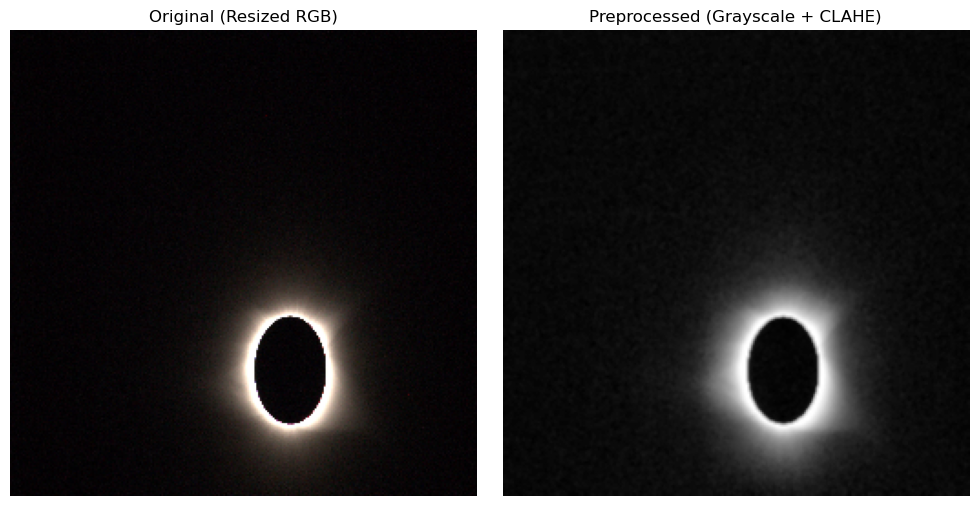

In [23]:
# --- Paths ---
train_dir = r"C:\Users\chris\Downloads\eclipse-megamovie (2)\eclipse-megamovie\train"
test_dir = r"C:\Users\chris\Downloads\eclipse-megamovie (2)\eclipse-megamovie\test"
train_csv = r"C:\Users\chris\Downloads\eclipse-megamovie (2)\eclipse-megamovie\train.csv"
test_csv = r"C:\Users\chris\Downloads\eclipse-megamovie (2)\eclipse-megamovie\test.csv"

# --- Load label files ---
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# --- Add full paths ---
train_df['path'] = train_df['image_id'].apply(lambda x: os.path.join(train_dir, x))
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join(test_dir, x))

# --- Preprocessing ---
def preprocess_image(path, size=(256, 256)):
    img = cv2.imread(path)                                          # read image from file path
    img = cv2.resize(img, size)                                     # resize to 256x256
    img = cv2.GaussianBlur(img, (3, 3), 0)                          # apply gaussian blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                    # convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))     # create CLAHE
    return clahe.apply(gray)                                        # return preprocessed image

# --- Select a random sample ---
sample_path = random.choice(train_df['path'].tolist())
original_img = cv2.imread(sample_path)
original_img = cv2.resize(original_img, (256, 256))                 # match preprocessing size

preprocessed_img = preprocess_image(sample_path)

# --- Convert BGR to RGB for displaying with matplotlib ---
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# --- Display original and preprocessed ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original (Resized RGB)")
plt.imshow(original_img_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Preprocessed (Grayscale + CLAHE)")
plt.imshow(preprocessed_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
